# Cost Allocation

This tutorial explores cost allocation in energy communities, and is based on the paper [1]. \
We allocate cost ex-post and centrally wish to base the payment of each community member on the cost their participation caused. \
A community controller computes optimal dispatch within the community. \
It is modeled as a self-contained algorithmic entity that the EC members democratically administrate.

A well-known approach from the literature allocates the Shapley value as payment for each member. \
This is implemented in CommonPower with ```NativeShapleySimulator``` and ```CostAllocator```.

The work in [1] demonstrates that this has unfavorable implications for members providing flexibility (e.g. due to storage capacity). \
This is because cost arising from inaccurate forecasts of the community controller will always at least in part be assigned to these members since forecasts do not matter without flexibility. \
The authors show that fair allocation under such imperfect knowledge can be represented with a number of conditions that represent a Pareto front. \
The proposed approach centrally computes members' Shapley values under perfect knowledge and then adjusts their payments via a multi-objective optimal program, guaranteeing a Pareto optimal allocation. \
This is implemented in CommonPower with ```UncertaintyAwareShapleySimulator``` and ```POIKAllocator``` (Pareto optimal imperfect knowedge).


[1] [M. Eichelbeck and M. Althoff, "Fair Cost Allocation in Energy Communities under Forecast Uncertainty,"
    in IEEE Open Access Journal of Power and Energy, 2024, doi: 10.1109/OAJPE.2024.3520418.](https://doi.org/10.1109/OAJPE.2024.3520418)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib

from datetime import timedelta, datetime
import matplotlib.pyplot as plt

from commonpower.core import System
from commonpower.models.components import *
from commonpower.models.buses import *
from commonpower.models.powerflow import *
from commonpower.data_forecasting import *
from commonpower.control.controllers import *
from commonpower.control.runners import *
from commonpower.modeling.param_initialization import *

from commonpower.extensions.cost_allocation import *


## System Setup

Our example is based on a system with 3 typical households:
1. Prosumer with Load and PV generation.
2. Storage provider with Load and ESS.
3. Consumer with Load. 

Their load and generation profiles are based on the [SimBench](https://simbench.de/de/datensaetze/) dataset "1-LV-rural2--1-sw". 

CommonPower provides the ```EnergyCommunity``` node that all members are added to. \
Since the energy community trades the joint power of all members, it is assigned its own price data provider. \
For simplitiy, we model perfectly known fixed rates. 

We simulate 3 days with a controller sample time of 1h.

In [3]:
# Parameters
horizon = timedelta(hours=24 * 3)
frequency = timedelta(hours=1)
sim_steps = 24 * 3
start_datetime = datetime(2016, 6, 25)

In [4]:
def spawn_data_sources(
    forecaster_class: Forecaster.__class__ = PerfectKnowledgeForecaster,
    **forecaster_kwargs
):

    # path to data profiles
    current_path = pathlib.Path().absolute()
    data_path = current_path / 'data'
    data_path = data_path.resolve()

    load_data = CSVDataSource(data_path  / '1-LV-rural2--1-sw' / 'LoadProfile.csv',
        delimiter=";", 
        datetime_format="%d.%m.%Y %H:%M", 
        rename_dict={"time": "t", "H0-A_pload": "p", "H0-A_qload": "q"},
        auto_drop=True, 
        resample=frequency).apply_to_column("p", lambda x: 2*x).apply_to_column("q", lambda x: 0.0)

    price_data = ConstantDataSource({
        "psis": 0.08,  # the household gets payed 0.08 for each kWh transferred to the external grid
        "psib": 0.34  # the houshold pays 0.34 for each imported kWh
        }, date_range=load_data.get_date_range()
    )
    
    pv_data = CSVDataSource(data_path / '1-LV-rural2--1-sw' / 'RESProfile.csv', 
        delimiter=";", 
        datetime_format="%d.%m.%Y %H:%M", 
        rename_dict={"time": "t", "PV3": "p"},
        auto_drop=True, 
        resample=frequency).apply_to_column("p", lambda x: -15*x)

    load_dp = DataProvider(load_data, forecaster_class(frequency=frequency, horizon=horizon, **forecaster_kwargs))
    price_dp = DataProvider(price_data, PerfectKnowledgeForecaster(frequency=frequency, horizon=horizon))
    pv_dp = DataProvider(pv_data, forecaster_class(frequency=frequency, horizon=horizon, **forecaster_kwargs))
    
    return (
        load_dp, price_dp, pv_dp        
    )

In [5]:
def spawn_sys(
    forecaster_class: Forecaster.__class__ = PerfectKnowledgeForecaster,
    **forecast_kwargs
) -> tuple[DeploymentRunner, OptimalController]:
    
    (load_dp, price_dp, pv_dp) = spawn_data_sources(forecaster_class, **forecast_kwargs)

    household1 = RTPricedBus("Household1").add_data_provider(price_dp)
    household2 = RTPricedBus("Household2").add_data_provider(price_dp)
    household3 = RTPricedBus("Household3").add_data_provider(price_dp)

    load1 = Load("Load").add_data_provider(load_dp)
    load2 = Load("Load").add_data_provider(load_dp)
    load3 = Load("Load").add_data_provider(load_dp)
    
    # pv generator
    pv = RenewableGen("PV").add_data_provider(pv_dp)
    
    capacity_ess = 15  # kWh
    ess = ESSLinear("ESS", {
        'rho': 0.001,  # charging/discharging 1 kWh incurs a cost of wear of 0.001
        'p': [-3, 3],  # active power limits
        'q': [0, 0],  # reactive power limits
        'etac': 0.98,  # charging efficiency
        'etad': 0.98,  # discharging efficiency
        'etas': 0.99,  # self-discharge (after one time step 99% of the soc is left)
        'soc': [0.1 * capacity_ess, 0.9 * capacity_ess],  # soc limits
        "soc_init": ConstantInitializer(0.5 * capacity_ess)  # initial soc at the start of simulation
    })

    # external grid connection
    ext_grid = ExternalGrid("ExternalGrid")
    
    # add components to households
    household1.add_node(load1).add_node(pv)  # prosumer
    household2.add_node(load2).add_node(ess)  # storage provider
    household3.add_node(load3)  # consumer
    
    # create energy community and configure grand coalition
    community = EnergyCommunity("Community").add_data_provider(price_dp)
    community.add_node(household1).add_node(household2).add_node(household3)
    
    sys = System(power_flow_model=PowerBalanceModel()).add_node(community).add_node(ext_grid)

    # Show the system set-up
    sys.pprint()
    
    return sys

The impact of imperfect knowledge centrally depends on the used forecaster. 

In [6]:
sys = spawn_sys(PersistenceForecaster, look_back=timedelta(weeks=1))


SYSTEM OVERVIEW 
 
Nodes: 
    (EnergyCommunity): Community  
       (RTPricedBus): Household1  
          (Load): Load  
          (RenewableGen): PV  
       (RTPricedBus): Household2  
          (Load): Load  
          (ESSLinear): ESS  
       (RTPricedBus): Household3  
          (Load): Load  
    (ExternalGrid): ExternalGrid  

Lines: 



## Simulation

The Shapley simulation can take a long time since the number of possible sub-coalition increases combinatorically with the number of members. \
For large systems, we use sampling to limit the computational load. \
For our example system, we have to compute the dispatch trajectory over 7 different system setups (coalitions).

In [7]:
native_simulator = NativeShapleySimulator(
    sys=sys,
    community_controller=OptimalController("ec_manager"),
    horizon=horizon,
    dt=frequency,
)
sim_result = native_simulator.simulate(
    sim_steps, start_datetime
)

100%|██████████| 72/72 [00:54<00:00,  1.32it/s]


In [8]:
uncertainy_aware_simulator = UncertaintyAwareShapleySimulator(
    sys=sys,
    community_controller=OptimalController("ec_manager"),
    horizon=horizon,
    dt=frequency,
)
uncertainty_aware_sim_result = uncertainy_aware_simulator.simulate(
    sim_steps, start_datetime
)

100%|██████████| 72/72 [00:55<00:00,  1.31it/s]


## Allocation

The cost of ignorance (CoI) is the difference between the realized cost and the cost under perfect knowledge. \
The CoI is what the Pareto Optimal Allocation redistributes in addition to the perfect knowledge Shapley payments. \
For the POIK allocation we choose an objective function weight of 0.8, which puts a the focus on the minimization of worst-case regret (difference between imperfect knowledge payment and stand-alone perfect knowledge cost). \
Please refer to [1] for more details.

In [9]:
coi = uncertainty_aware_sim_result.realized_cost - sum(uncertainty_aware_sim_result.shapleys)
coi

0.6384681547587316

In [10]:
native_allocation = CostAllocator(sim_result).allocate()
native_allocation

[-6.511463033330798, 1.3205114967599825, 1.9274928916761644]

In [11]:
poik_allocator = POIKCostAllocator(uncertainty_aware_sim_result)
poik_allocation, poik_coi_shares, poik_regrets = poik_allocator.allocate(mu=0.8)
poik_allocation, poik_coi_shares, poik_regrets

([-5.80540137372167, 0.5596107051600283, 1.982332023666992],
 [0.4166666660030984, 0.4166666660030984, 0.1666666679938033],
 [-1.988202213721669, -1.0293024729332225, -0.4375379063330085])

Above, we can see the difference in allocation:
The POIK allocation assigns 41% of the CoI to the prosumer and storage provider, respectively. This is because their regret is lower than the regret of the consumer and the allocation attempts to minimize the worst regret across all members. The fact that all their regrets are negative means that all members benefit from being part of the energy community. \
Overall, the storage provider has a significantly lower payment compared to the native allocation, underlining its skewness against flexibility-providing members under imperfect knowledge.

Below, we use the sweep functinality of the ```POIKAllocator``` to generate the Pareto front of fair allocations. \
On the x-axis we plot the normalized objective function representing the minimum deviation (2-norm) from the perfect knowlege allocation. \
On the y-axis we plot the normalized objective function representing the minimum worst-case regret.

In [12]:
num_points = 100
sweep_results, pareto_front = poik_allocator.sweep(p=2, mu=[x/num_points for x in range(0, num_points+1, 1)])

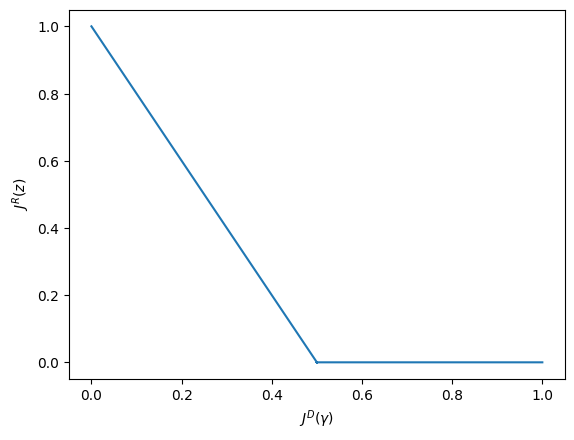

In [13]:
plt.plot([x[0] for x in pareto_front], [x[1] for x in pareto_front])
plt.xlabel('$J^D(\gamma)$')
plt.ylabel('$J^R(z)$')
plt.show()